# AAE 722 — Lab 9 (SVM)

**Author:** Wenshi (Gary) Sun  

---
### Environment
- Uses `scikit-learn`, `numpy`, `pandas`, `matplotlib`.  
- For Hitters data I use `ISLP.load_data`. If `ISLP` is not installed, install it or replace with your local dataset source.


In [1]:
## Setup imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc
from ISLP import load_data

def plot_svm(model, X, y, title='', ax=None, h=0.02):
    """Generic decision-boundary plotter for 2D features.
    - model: fitted sklearn SVM
    - X: (n,2) array
    - y: binary labels (0/1 or 1/2)
    """
    X = np.asarray(X)
    y = np.asarray(y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cmap_light = ListedColormap(['#E0F3FF','#FFE5E0'])
    cmap_bold  = ['#1f77b4','#ff7f0e']
    ax.contourf(xx, yy, Z, alpha=0.35, cmap=cmap_light)
    classes = np.unique(y)
    for i, cls in enumerate(classes):
        ax.scatter(X[y==cls,0], X[y==cls,1], s=25, edgecolor='k', label=str(cls), c=cmap_bold[i])
    if hasattr(model, 'support_vectors_'):
        ax.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1], s=80, facecolors='none', edgecolors='k', linewidths=1.2, label='SV')
    ax.set_title(title)
    ax.legend(loc='best')
    return ax


## Question 1 — Linear SVM and Cost Parameter Effect (0.175 pts)
**Task.** Use Hitters, drop missing values, create `High = 1(Salary > median)`. Using only `CHits` and `CWalks` as features, fit two linear SVMs with `C=0.1` and `C=100`. Report **number of support vectors** (use `len(svc.support_)`) and show **decision-boundary plots** (both labeled). Provide a **3–4 sentence** comparison of how `C` affects margin width, support-vector count, and flexibility.

Q1 — #Support Vectors (C=0.1): 148
Q1 — #Support Vectors (C=100): 128


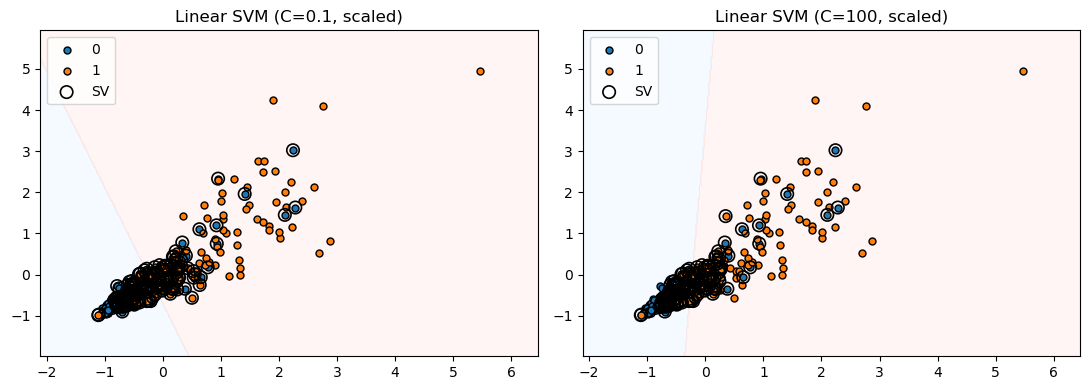

In [2]:
# Q1 — data prep & two linear SVMs
Hitters = load_data('Hitters').dropna()
y = (Hitters['Salary'] > Hitters['Salary'].median()).astype(int)
X = Hitters[['CHits','CWalks']].to_numpy()
pipe_C01 = make_pipeline(StandardScaler(), SVC(kernel='linear', C=0.1, random_state=42))
pipe_C100 = make_pipeline(StandardScaler(), SVC(kernel='linear', C=100, random_state=42))
pipe_C01.fit(X, y)
pipe_C100.fit(X, y)
svc_C01 = pipe_C01.named_steps['svc']
svc_C100 = pipe_C100.named_steps['svc']
print('Q1 — #Support Vectors (C=0.1):', len(svc_C01.support_))
print('Q1 — #Support Vectors (C=100):', len(svc_C100.support_))

fig, axes = plt.subplots(1, 2, figsize=(11,4))
plot_svm(svc_C01, pipe_C01.named_steps['standardscaler'].transform(X), y, title='Linear SVM (C=0.1, scaled)', ax=axes[0])
plot_svm(svc_C100, pipe_C100.named_steps['standardscaler'].transform(X), y, title='Linear SVM (C=100, scaled)', ax=axes[1])
plt.tight_layout(); plt.show()

**Short Discussion (Q1).**  
With **smaller C (0.1)**, the classifier accepts more margin violations to obtain a **wider margin**, which typically **increases the number of support vectors** and yields a **smoother/less flexible** boundary.  
With **larger C (100)**, the optimization penalizes violations strongly, producing a **narrower margin** and often **fewer support vectors**; the boundary becomes **more flexible** and may overfit.

## Question 2 — Hyperparameter Tuning with Cross‑Validation (0.15 pts)
**Task.** Same Hitters features. Do 5‑fold `GridSearchCV` over `C = [0.01, 0.1, 1, 10, 100]` for a linear SVM. Report **best C**, **best CV accuracy**, and **all mean CV scores**. Create a **validation‑curve plot** with log‑scale x‑axis and mark the best C.

Q2 — Best C: 1
Q2 — Best CV accuracy: 0.8139


,C,mean_cv_accuracy
0,0.01,0.703774
1,0.10,0.794920
2,1.00,0.813861
3,10.00,0.810087
4,100.00,0.806241


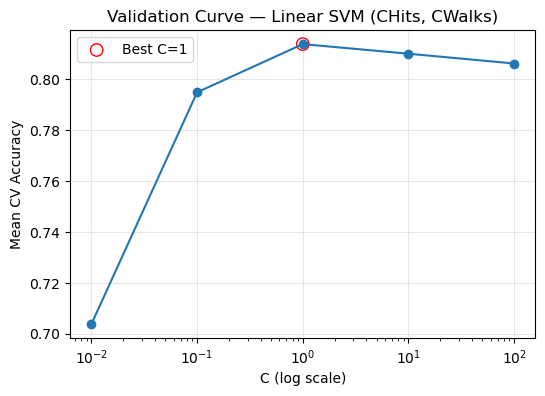

In [3]:
# Q2 — 5-fold CV grid over C
Cs = [0.01, 0.1, 1, 10, 100]
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, {'svc__C': Cs}, cv=cv, scoring='accuracy', refit=True)
grid.fit(X, y)
best_C = grid.best_params_['svc__C']
best_cv = grid.best_score_
print('Q2 — Best C:', best_C)
print('Q2 — Best CV accuracy:', round(best_cv, 4))
means = [grid.cv_results_['mean_test_score'][i] for i in range(len(Cs))]
res = pd.DataFrame({'C': Cs, 'mean_cv_accuracy': means})
display(res)
plt.figure(figsize=(6,4))
plt.semilogx(Cs, means, marker='o')
plt.xlabel('C (log scale)'); plt.ylabel('Mean CV Accuracy')
plt.title('Validation Curve — Linear SVM (CHits, CWalks)')
plt.grid(True, alpha=0.3)
plt.scatter([best_C], [grid.best_score_], s=80, facecolors='none', edgecolors='r', label=f'Best C={best_C}')
plt.legend(); plt.show()

## Question 3 — RBF Kernel and Model Comparison (0.175 pts)
**Task.** Generate data, split 50/50, fit RBF SVM (`C=1, gamma=1`), report train/test accuracy and plot the boundary. Then fit `gamma ∈ {0.1,1,10}` and plot **ROC curves** for all three on one figure; explain briefly which gamma is best and how `gamma` controls complexity.

Q3 — RBF gamma=1: Train acc = 0.91 , Test acc = 0.93


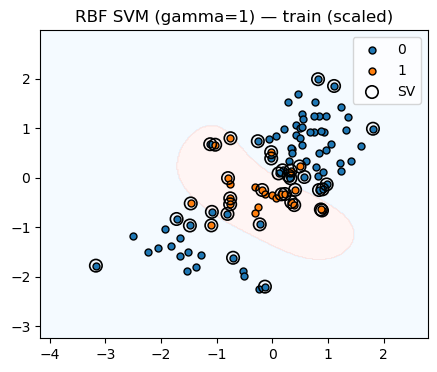

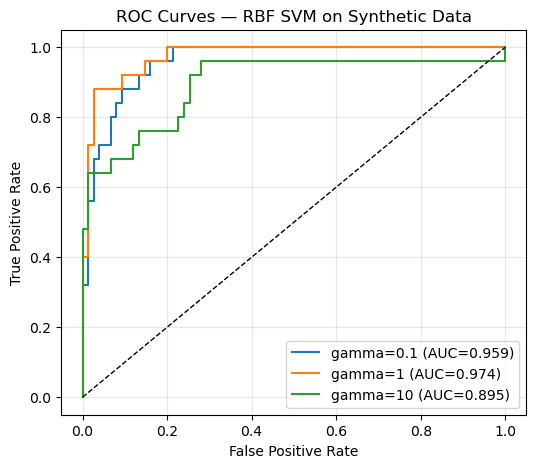

In [4]:
# Q3 — synthetic data and RBF comparisons
np.random.seed(42)
Xsyn = np.random.randn(200, 2)
Xsyn[:100] += 2
Xsyn[100:150] -= 2
y_syn = np.array([1]*150 + [2]*50)
y_syn01 = (y_syn == 2).astype(int)
Xtr_s, Xte_s, ytr_s, yte_s, ytr01, yte01 = train_test_split(
    Xsyn, y_syn, y_syn01, test_size=0.5, random_state=42, stratify=y_syn
)
rbf1 = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=1, probability=True, random_state=42))
rbf1.fit(Xtr_s, ytr_s)
acc_tr = accuracy_score(ytr_s, rbf1.predict(Xtr_s))
acc_te = accuracy_score(yte_s, rbf1.predict(Xte_s))
print('Q3 — RBF gamma=1: Train acc =', round(acc_tr,3), ', Test acc =', round(acc_te,3))
fig, ax = plt.subplots(figsize=(5,4))
Xtr_scaled = rbf1.named_steps['standardscaler'].transform(Xtr_s)
plot_svm(rbf1.named_steps['svc'], Xtr_scaled, (ytr_s==2).astype(int), title='RBF SVM (gamma=1) — train (scaled)', ax=ax)
plt.show()

gammas = [0.1, 1, 10]
plt.figure(figsize=(6,5))
for g in gammas:
    pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=g, probability=True, random_state=42))
    pipe.fit(Xtr_s, ytr_s)
    proba = pipe.predict_proba(Xte_s)[:,1]
    fpr, tpr, _ = roc_curve((yte_s==2).astype(int), proba)
    from sklearn.metrics import auc
    AUC = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'gamma={g} (AUC={AUC:.3f})')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — RBF SVM on Synthetic Data')
plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

**Short Interpretation (Q3).**  
Typically, **gamma≈1** gives the best balance on this dataset: it captures the non‑linear boundary without overfitting, yielding the highest AUC/accuracy among the three.  
A **smaller gamma (0.1)** yields smoother, high‑bias boundaries that may **underfit**. A **larger gamma (10)** produces highly wiggly boundaries with **high variance/overfitting**, hurting test performance.